# Sources

* [attention-is-all-you-need-pytorch](https://github.com/ruthvik92/attention-is-all-you-need-pytorch)
* [FrancescoSaverioZuppichini-ViT](https://github.com/ruthvik92/ViT)
* [vision-transformers-cifar10](https://github.com/ruthvik92/vision-transformers-cifar10)
* [ViT-pytorch-1](https://github.com/ruthvik92/ViT-pytorch-1)

**Some cool schedulers**
* [pytorch_warmup](https://github.com/ruthvik92/pytorch_warmup)
* [pytorch-cosine-annealing-with-warmup](https://github.com/ruthvik92/pytorch-cosine-annealing-with-warmup)

# Imports

In [1]:
import torch, time
import torchvision
from torch import nn
import torch.optim as optim
import pytorch_warmup as warmup
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from einops import rearrange, reduce, repeat
from transformer.Optim import ScheduledOptim
from transformer.randomaug import RandAugment
from einops.layers.torch import Rearrange, Reduce
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
#/home/visionteam/tf_tutorials/attention-is-all-you-need-pytorch/train.py

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-n20znzhq because the default path (/home/visionteam/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Check `Torch` version and `CUDA` availability.

In [2]:
print('PyTorch version:{}'.format(torch.__version__))
print('Is CUDA available:{}'.format(torch.cuda.is_available()))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device is{}'.format(device))

PyTorch version:1.7.1
Is CUDA available:True
Device iscuda:0


# Load, prepare and visualize the `CIFAR10` dataset.

In [3]:
batch_size = 100
size = 32
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


N = 2; M = 14;
transform_train.transforms.insert(0, RandAugment(N, M))
    
transform_test = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='/home/visionteam/data/', train=True,
                                        download= True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle= True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='/home/visionteam/data/', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print('Number of examples in the training set:{}'.format(len(trainset)))

Number of examples in the training set:50000


In [5]:
print('Number of examples in the training set:{}'.format(len(testset)))

Number of examples in the training set:10000


In [6]:
n_batches = len(trainloader)
print('Number of batches in the training data loader:{}'.format(n_batches))

Number of batches in the training data loader:500


## Display a few images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


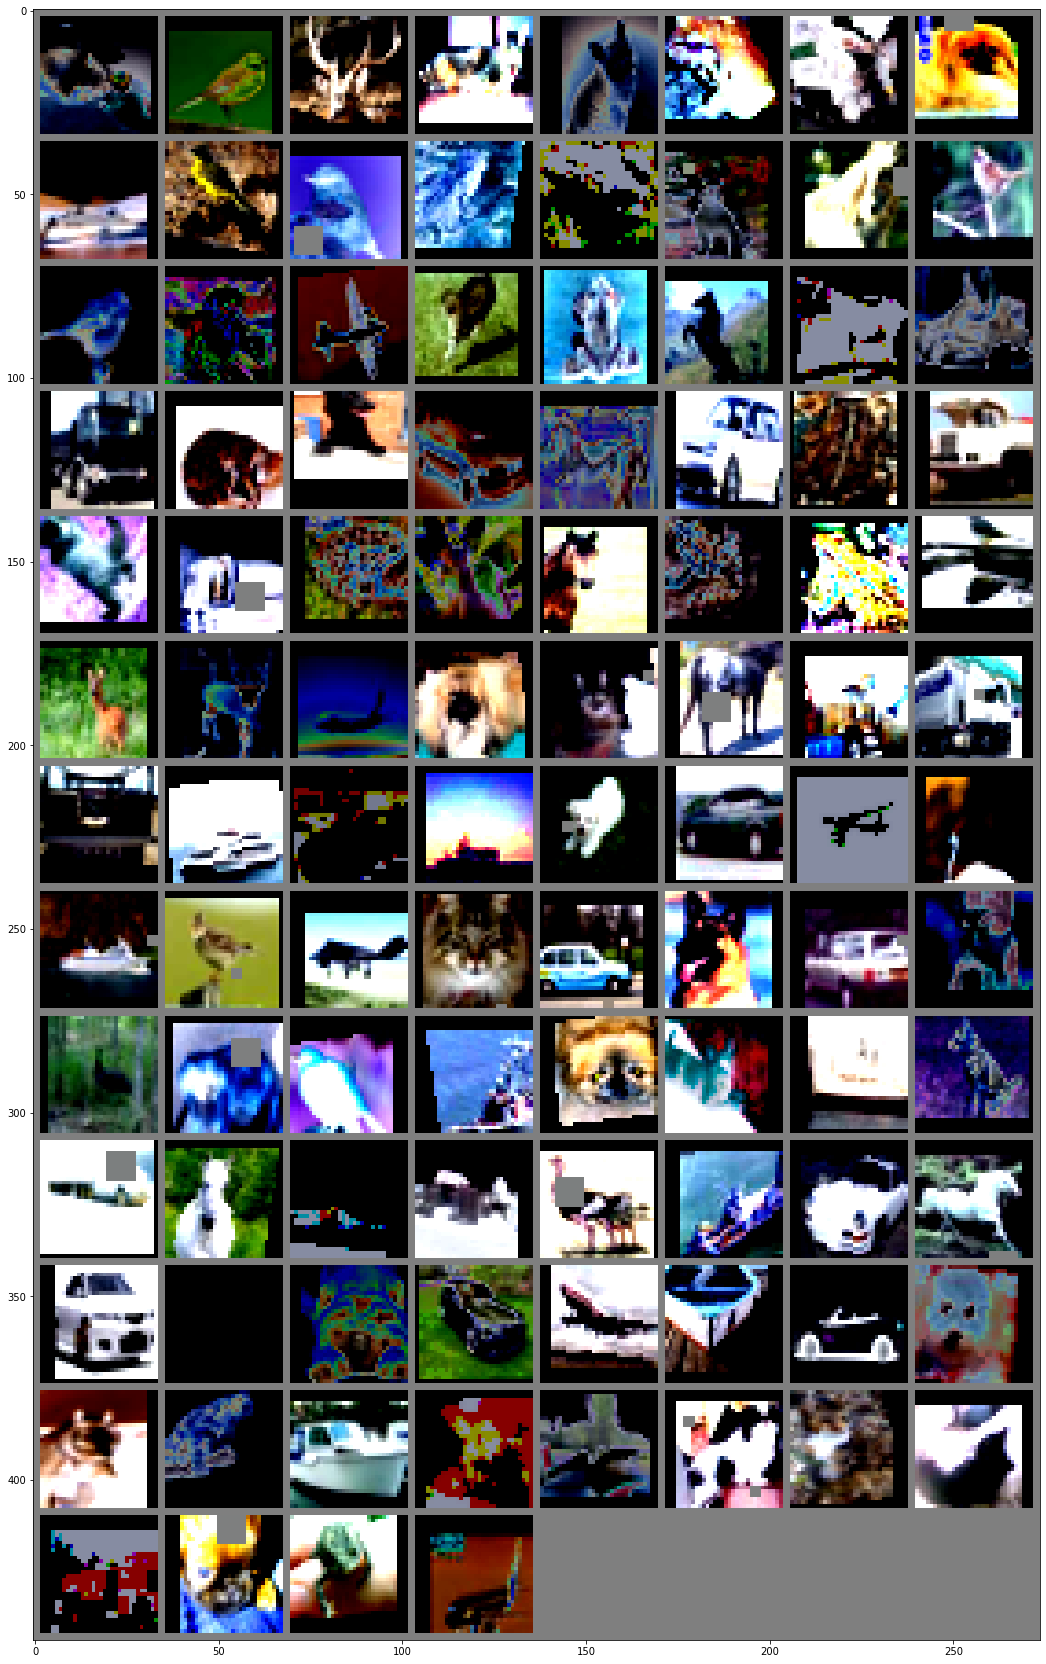

  cat  bird  deer   cat   cat  frog truck   dog  ship  bird  bird  frog  frog   dog horse  bird  bird  bird plane   cat  frog horse horse   cat truck   cat   dog   car horse   car  frog truck   cat  ship  frog  deer horse  frog  frog  bird  deer  deer plane   dog   cat horse truck truck truck  ship   car  ship   dog   car plane  bird  ship  bird plane   cat   car   dog   car   cat  bird   dog  bird  ship   dog   cat  ship   dog truck horse  deer truck  bird  ship   car horse   car horse   dog   car plane  ship   car   dog horse  frog  ship   cat plane   dog   cat   cat truck   dog  frog plane
Shapes of images:torch.Size([3, 32, 32])


In [7]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=[30, 30])
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
out = torchvision.utils.make_grid(images)
imshow(out)
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
print('Shapes of images:{}'.format(images[0].shape))

# ViT model

## ViT model
![alt text](ViTTransformerBlock_small.png "Encoder in ViT")

## Original transformer encoder model
![alt text](nlp_transf_encoder_small.png "Encoder in ViT")

## Positional and patch embedding layer

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size: int=4, d_model: int=512, img_size: int=32,
                n_conv_layers: int=1):
        self.patch_size = patch_size
        super().__init__()
        # using a conv layer instead of a linear one -> performance gains
        # same_conv_layer means the shapes of input and output images is same as opposed to valid mode conv.
        self.same_conv_layer_stack = nn.ModuleList([nn.Conv2d(in_channels, in_channels, kernel_size=5, stride=1, padding=2) \
                                                    for i in range(n_conv_layers)])
        self.conv_proj_layer = nn.Conv2d(in_channels, d_model, kernel_size=patch_size, stride=patch_size)
        self.re_arrange_layer = Rearrange('b e (h) (w) -> b (h w) e')
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.position_token = nn.Parameter(torch.randn((img_size // patch_size)**2 + 1, d_model))
        
                
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, *_ = x.shape
        for same_conv_layer in self.same_conv_layer_stack:
            x = same_conv_layer(x)
        convd_img = self.conv_proj_layer(x)
        #print('Output of convolution:{}'.format(convd_img.shape))
        re_arranged_ip = self.re_arrange_layer(convd_img)
        #print('Rearranged ip:{}'.format(re_arranged_ip.shape))
        cls_token = repeat(self.cls_token, '() n e -> b n e', b=b)
        #print('CLS token:{}'.format(cls_token.shape))
        concated_ip = torch.cat([cls_token, re_arranged_ip], axis=1)
        concated_ip += self.position_token
        #print('Concated ip:{}'.format(concated_ip.shape))
        
        return concated_ip

## Test the patch embedding layer

In [ ]:
src_img = torch.Tensor(np.random.randint(0, 255, size=(1,3, 32, 32)))
print('Original image:{}'.format(src_img.shape))
concated_ip = PatchEmbedding(n_conv_layers=2)(src_img)
print('projected and cls_toen concated image:{}'.format(concated_ip.shape))

## Multi-head attention (Review)

### Scaled dot product attention (on the decoder side)
* `Keys` and `Values` to the decoder come from the output of an encoder.
* `Queries` of the decoder come its scaled self attention module.
$$Attention(Q,K,V) = \frac{Softmax(Q \times K^{T}) \times V}{\sqrt{d_k}} $$
* Softmax is across columns (`axis=1` according to `NumPy` notation)
* Suppose you have two sentences, one in English and another in French. English sentence is `3` words long and the French sentence is `5` words long. 
* If embedding dimension is `512` then $Q \in R^{5 \times 512}$,  $K \in R^{3 \times 512}$, $V \in R^{3 \times 512}$. 
* $Softmax(Q \times K^{T}, axis=1) \in R^{5 \times 3}$, this is the attention matrix.
* Here $ Q \times K^{T} $ is analogous to dot product between two vectors, $ \hat{\mathbf{a}} \cdot \hat{\mathbf{b}} = \left|a\right| \left|b\right|\cos(\theta)$ where $\theta$ is the angle between the two vectors `a`, and `b`.
* Attention tries to see how each of the French words correlates with each of the English words.
* This results in a matrix of `5x3` shape now, the reason you take softmax across the columns (`axis=1`) is..
* You're trying to normalize the values of correlation between each English word and the French word.
* If you take softmax across rows (`axis=0`) it is not the same.
* Once $Softmax(Q \times K^{T}) \times V$ is performed, each row of the attention matrix linearly scales all the columns of the vector `V` to obtain one row of the resulting matrix. (Basically, this is matrix multiplication). An important thing to note here is that we're linearly combining columns(i.e., scaling all the words in the batch as per the attention values).

````
>>> a = np.random.rand(5,3)
>>> print(a)
>>> 
array([[4.13818936e-01, 2.14551343e-01, 9.26387294e-01],
       [7.06054611e-01, 2.97606563e-01, 6.59275117e-01],
       [9.50130365e-01, 1.12366506e-01, 8.09734671e-01],
       [7.74393414e-01, 2.35286464e-01, 7.00733014e-02],
       [2.89013804e-02, 6.29521814e-01, 9.07528664e-04]])
````

````
>>> num_exp_a = np.exp(a)
>>> print(num_exp_a)
>>> 
array([[1.51258323, 1.23930575, 2.52536926],
       [2.02598218, 1.34663187, 1.93339034],
       [2.58604677, 1.11892288, 2.24731163],
       [2.16927588, 1.26527117, 1.0725868 ],
       [1.02932308, 1.87671295, 1.00090794]])
````

````
>>> denom_exp_a = np.exp(a.sum(axis=1))
>>> print(denom_exp_a.shape)
>>> (5,)
>>> denom_exp_a = denom_exp_a.reshape(-1,1) #reshape to (5,1)
>>> print(denom_exp_a)
>>> 
array([[4.73393875],
       [5.27477641],
       [6.50279147],
       [2.94395283],
       [1.93349786]])
````

````
>>> print(num_exp_a / denom_exp_a)
>>> 
array([[0.31951897, 0.26179167, 0.53346048],
       [0.38408873, 0.25529648, 0.36653503],
       [0.39768256, 0.17206809, 0.34559183],
       [0.73685823, 0.4297865 , 0.36433559],
       [0.53236319, 0.97063099, 0.51766695]])
````

````
>>> row_1 = np.array([1.51258323, 1.23930575, 2.52536926])
>>> print(row_1 / 4.73393875)
>>> array([0.31951897, 0.26179167, 0.53346048])
````

In [9]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3)) 
        #(1 x 8 x 65 x 64) x (1 x 8 x 64 x 65)--> (1 x 8 x 65 x 65)
        # ------ q -------- x -------- kT -----

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1)) # (1 x 8 x 65 x 65)
        #print(q.shape, k.shape, v.shape)
        output = torch.matmul(attn, v) #(1 x 8 x 65 x 65) x (1 x 8 x 65 x 64) --> (1 x 8 x 65 x 64)

        #return output, attn # (1 x 8 x 65 x 64) and (1 x 8 x 65 x 65)
        return output

### Multi-head attention
* This module contains the `Multi-Head Attention`, `Add & Norm blocks`, and the residual connection from the encoder figure in section 4.2. [Original transformer encoder model](#Original-transformer-encoder-model)

In [10]:

class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q

        # Pass through the pre-attention projection: b x lq x (n*dv) = (1 x 65 x 512)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k) #(1 x 65 x 512) --> (1 x 65 x 8 x 64)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k) #(1 x 65 x 512) --> (1 x 65 x 8 x 64)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v) #(1 x 65 x 512) --> (1 x 65 x 8 x 64)

        # Transpose for attention dot product: b x n x lq x dv = (1 x 8 x 65 x 64)
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        #q, attn = self.attention(q, k, v, mask=mask) # (1 x 8 x 65 x 64) and (1 x 8 x 65 x 65)
        q  = self.attention(q, k, v, mask=mask) # (10 x 8 x 12 x 64) and (10 x 8 x 12 x 12)
        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        # q.transpose(1, 2) --> (1 x 65 x 8 x 64)
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1) #(1 x 65 x 512)
        q = self.dropout(self.fc(q)) ## (1 x 65 x 512) x (512 x 512) --> (1 x 65 x 512)
        q += residual

        q = self.layer_norm(q)

        #return q, attn
        return q


### Test multi-head attention class

In [ ]:
n_head = 8
n_layers = 6
d_k = 64
d_v = 64
batch = 1
d_inner = 512
d_model = 512
q = concated_ip
k = q
v = q
print('Input to the multi head attention:{}'.format(q.shape))
multi_head_block = MultiHeadAttention(n_head=n_head, d_model=d_model, d_k=d_k, d_v=d_v)
#q, self_attn = multi_head_block(q, k ,v)
q = multi_head_block(q, k ,v)
#print('Shape of q:{}, Shape of self attention:{}'.format(q.shape, self_attn.shape))
print('Shape of q:{}'.format(q.shape))

### Feedforward Layer
* This module contains the `Feed Forward`, `Add & Norm blocks`, and the residual connection from the encoder figure in section 4.2. [Original transformer encoder model](#Original-transformer-encoder-model)

In [11]:
class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x
        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x


### Complete encoder layer
* This module contains the `Multi-Head Attention`, `Add & Norm blocks`, residual,  `Feed Forward`, `Add & Norm blocks`, and the residual connection from the encoder figure in section 4.2. [Original transformer encoder model](#Original-transformer-encoder-model)
* Note that this module does not have the patch embedding in it. 

In [12]:
class EncoderLayer(nn.Module):
    ''' Compose with two layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        #enc_output, enc_slf_attn = self.slf_attn(
        #    enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        if(type(enc_output) == tuple):
            enc_output, enc_slf_attn = enc_output
        enc_output = self.pos_ffn(enc_output)
        #return enc_output, enc_slf_attn
        return enc_output

### Encoder layer + Patch embedding
* Without the patch embedding, NN has no idea about the location of the each of the $4 \times 4$ patches from the image. 

In [13]:
class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_layers, n_head, d_k, d_v,
            d_model, d_inner, dropout=0.1, n_conv_layers=1):

        super().__init__()

        self.position_enc = PatchEmbedding(d_model=d_model, n_conv_layers=n_conv_layers)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout) \
                                          for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.d_model = d_model

    def forward(self, input_image, return_attns=False):

        enc_slf_attn_list = []

        # -- Forward
        enc_output = self.dropout(self.position_enc(input_image))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            #enc_output, enc_slf_attn = enc_layer(enc_output, slf_attn_mask=None)
            #enc_slf_attn_list += [enc_slf_attn] if return_attns else []
            enc_output = enc_layer(enc_output, slf_attn_mask=None)

        #if return_attns:
        #    return enc_output, enc_slf_attn_list
        return enc_output

### Testing the stack of Encoder layers.

In [ ]:
n_head = 8
n_layers = 6
d_k = 64
d_v = 64
d_inner = 512
d_model = 512

In [ ]:
src_img = torch.Tensor(np.random.randint(0, 255, size=(2,3, 32, 32)))
print('Original image:{}'.format(src_img.shape))
encoder = Encoder(n_layers=6, n_head=6, d_k=d_k, d_v=d_v, d_model=d_model, d_inner=d_inner, n_conv_layers=2)
enc_output = encoder(input_image=src_img)
print('Encoder output:{}'.format(enc_output.shape))

## Classifier section
* Dimensions of the output tensor can be reduced by average pooling, learnable pooling, or simply using only the `cls_token` that was introduced in the patch embedding stage.

### Classifier head with average pooling
* `self.reduction_layer = Reduce('b n e -> b e', reduction='mean')` performs $R^{2 \times 65 \times 512} \rightarrow R^{2 \times 1 \times 512}$ assuming  $d\_model \in R^{512}$, $enc\_output \in R^{2 \times 65 \times 512}$, and the batch size is 2.

In [14]:
class ClassificationHeadWithAvgPooling(nn.Module):
    def __init__(self, d_model: int = 512, n_classes: int = 10):
        super().__init__()
        self.reduction_layer = Reduce('b n e -> b e', reduction='mean')
        self.layer_norm = nn.LayerNorm(d_model) 
        self.linear_layer = nn.Linear(d_model, n_classes)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        reduced_encoder_op = self.reduction_layer(x)
        #print('Reduced encoder shape:{}'.format(reduced_encoder_op.shape))
        layer_normed_reduced = self.layer_norm(reduced_encoder_op)
        output = self.linear_layer(layer_normed_reduced)
        return output

### Testing the classifier head

In [ ]:
classification_head = ClassificationHeadWithAvgPooling()
print('Input to the classifier:{}'.format(enc_output.shape))
classification_op = classification_head(enc_output)
print('Classification output:{}'.format(classification_op.shape))

### Classifier with learnable pooling 


`temp_layer = nn.Linear(d_model, 1)`

`temp_layer_op = temp_layer(enc_output)`

`print(temp_layer_op.shape)`

torch.Size([2, 65, 1])

`temp_layer_op = temp_layer_op.transpose(-1, 1)`

`temp_layer_op = F.softmax(temp_layer_op, dim=-1)` #softmax(g(XL)T) in R^{bx1xn}

`print(temp_layer_op.shape)`

torch.Size([2, 1, 65])

`temp_z = torch.matmul(temp_layer_op, enc_output)` #[2,1,65]x[2,65,512], softmax(g(XL)T) x XL in R^{bx1xd} 

`print(temp_z.shape)`

torch.Size([2, 1, 512])

* the above code performs $R^{2 \times 65 \times 512} \rightarrow R^{2 \times 1 \times 512}$ assuming  $d\_model \in R^{512}$, $enc\_output \in R^{2 \times 65 \times 512}$, and the batch size is 2. The same is implemented in the below class `ClassificationHeadWithLearnablePooling` lines `10-14`.


In [15]:
class ClassificationHeadWithLearnablePooling(nn.Module):
    def __init__(self, d_model: int = 512, n_classes: int = 10):
        super().__init__()
        self.reduction_layer = nn.Linear(d_model, 1)
        self.layer_norm = nn.LayerNorm(d_model) 
        self.linear_layer = nn.Linear(d_model, n_classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ### Learnable pooling
        reduction_layer_op = self.reduction_layer(x)
        reduction_layer_op = reduction_layer_op.transpose(-1, 1)
        reduction_layer_op = F.softmax(reduction_layer_op, dim=-1)
        enc_output = torch.matmul(reduction_layer_op, x)
        enc_output = enc_output.squeeze(1) #converts torch.Size([2, 1, 512]) -> torch.Size([2, 512])
        ## end of learnable pooling
        
        ## layer norm and a fully connected layer
        layer_normed_reduced = self.layer_norm(enc_output)
        output = self.linear_layer(layer_normed_reduced)
        #output = self.linear_layer(enc_output)
        return output

### Testing the classifier head.

In [ ]:
classification_head = ClassificationHeadWithLearnablePooling()
print('Input to the classifier:{}'.format(enc_output.shape))
classification_op = classification_head(enc_output)
print('Classification output:{}'.format(classification_op.shape))

### Classifier head with truncated `cls_token`.

In [16]:
class ClassificationHeadClsTokenPooling(nn.Module):
    def __init__(self, d_model: int = 512, n_classes: int = 10):
        super().__init__()
        self.layer_norm = nn.LayerNorm(d_model) 
        self.linear_layer = nn.Linear(d_model, n_classes)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        reduced_encoder_op = x[:,-1,:]
        #print('Reduced encoder shape:{}'.format(reduced_encoder_op.shape))
        layer_normed_reduced = self.layer_norm(reduced_encoder_op)
        output = self.linear_layer(layer_normed_reduced)
        return output

### Testing the classifier head

In [ ]:
classification_head = ClassificationHeadClsTokenPooling()
print('Input to the classifier:{}'.format(enc_output.shape))
classification_op = classification_head(enc_output)
print('Classification output:{}'.format(classification_op.shape))

## Full ViT model

In [17]:
def make_classifier_head(classifier_type='average_pooling', d_model=512, n_classes=10):
    if(classifier_type == 'average_pooling'):
        classifier_head = ClassificationHeadWithAvgPooling(d_model=d_model, n_classes=n_classes)
    elif(classifier_type == 'learnable_pooling'):
        classifier_head = ClassificationHeadWithLearnablePooling(d_model=d_model, n_classes=n_classes)
    elif(classifier_type == 'cls_token_pooling'):
        classifier_head = ClassificationHeadClsTokenPooling(d_model=d_model, n_classes=n_classes)
    else:
        print('classifier_type of type:{} is not yet supported'.format(classifier_type))
    return classifier_head

In [18]:
class ViT(nn.Module):
    def __init__(self, n_layers, n_head, d_k, d_v, d_model, d_inner, n_classes, 
                 classifier_type='average_pooling', dropout=0.1, n_conv_layers=1):
        super().__init__()
        self.encoder = Encoder(n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v, d_model=d_model, 
                               d_inner=d_inner, n_conv_layers=n_conv_layers)
        self.classifier_head = make_classifier_head(classifier_type=classifier_type, d_model=d_model,
                                                   n_classes=n_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print(x.shape)
        #encoder_op = self.encoder(input_image=x)
        encoder_op = self.encoder(x)
        classifier_op = self.classifier_head(encoder_op)
        return classifier_op

## Initialize the complete ViT model

In [19]:
n_head = 8
n_layers = 6
d_k = 64
d_v = 64
batch = 1
d_inner = 512
d_model = 512
n_classes= 10
classifier_type = 'learnable_pooling'
n_conv_layers = 4
vit = ViT(n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v, d_model=d_model, d_inner=d_inner,
         n_classes=n_classes, n_conv_layers=n_conv_layers, classifier_type=classifier_type).to(device)
vit = torch.nn.DataParallel(vit)

### Testing the complete ViT model

In [ ]:
src_img = torch.Tensor(np.random.randint(0, 255, size=(2,3, 32, 32))).to(device)
print('Original image:{}'.format(src_img.shape))
vit_op = vit(src_img)
print('vit output:{}'.format(vit_op.shape))

## Summary of the model

In [20]:
summary(vit, (3, 32, 32), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]             228
            Conv2d-2            [-1, 3, 32, 32]             228
            Conv2d-3            [-1, 3, 32, 32]             228
            Conv2d-4            [-1, 3, 32, 32]             228
            Conv2d-5            [-1, 512, 8, 8]          25,088
         Rearrange-6              [-1, 64, 512]               0
    PatchEmbedding-7              [-1, 65, 512]               0
           Dropout-8              [-1, 65, 512]               0
         LayerNorm-9              [-1, 65, 512]           1,024
           Linear-10              [-1, 65, 512]         262,144
           Linear-11              [-1, 65, 512]         262,144
           Linear-12              [-1, 65, 512]         262,144
          Dropout-13            [-1, 8, 65, 65]               0
ScaledDotProductAttention-14           

## Make a learning rate scheduler

In [21]:
epochs = 500
gamma = 0.88
n_steps = epochs*n_batches
print('Total number of batches(steps):{}'.format(n_steps))
criterion = nn.CrossEntropyLoss()
lr = 0.03
optimizer = optim.SGD(vit.parameters(), lr=lr, momentum=0.9)
first_cycle_steps=int(n_batches*50) ## after 50 epochs, a cycle is completed.
print('Steps (batches) for the first cycle to complete:{}'.format(first_cycle_steps))
min_lr = lr / 6
print('Minimum learning rate:{} and maximum learning rate:{} for this scheduler'.format(min_lr, lr))
warmup_steps = int(first_cycle_steps / 2.0)
print('Warmup steps:{}'.format(warmup_steps))
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=first_cycle_steps, cycle_mult=1.0, 
                                          max_lr=lr, min_lr=min_lr, warmup_steps=warmup_steps, gamma=gamma) 


Total number of batches(steps):250000
Steps (batches) for the first cycle to complete:25000
Minimum learning rate:0.005 and maximum learning rate:0.03 for this scheduler
Warmup steps:12500


### Visualize the scheduler

Text(0, 0.5, 'Learning rate')

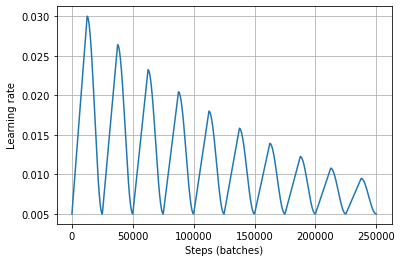

In [22]:
lrs = []
for i in range(n_steps):
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
plt.plot(list(range(len(lrs))), lrs)
plt.grid()
plt.xlabel('Steps (batches)')
plt.ylabel('Learning rate')

### Re-start the scheduler
* Because the state is not stored.

In [23]:
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=first_cycle_steps, cycle_mult=1.0, 
                                          max_lr=lr, min_lr=min_lr, warmup_steps=warmup_steps, gamma=gamma)

## Checkpointer

In [24]:
PATH = './cifar_net_{}extra_conv_{}_sgd_lr_{}_gamma_{}_{}_epochs_randaugs_{}_batch.pth'.format(n_conv_layers,
                                                                                      classifier_type,
                                                                                      lr, gamma, epochs, batch_size)
print('Checkpoints will be saved to:{}'.format(PATH))
def save_checkpoint(model, path):
    print('Saved checkpoint to:{}'.format(path))
    torch.save(model.state_dict(), path)

Checkpoints will be saved to:./cifar_net_4extra_conv_learnable_pooling_sgd_lr_0.03_gamma_0.88_500_epochs_randaugs_100_batch.pth


## Testing function

In [25]:
def test_accuracy():
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = vit(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the 10000 test images: %.2f %%' % (accuracy))
    return accuracy

## Start the training

In [26]:
best_test_accuracy = 0
test_accuracy_history = []
lrs_history = []
train_loss_history = []
for epoch in range(epochs):  # loop over the dataset multiple times
    t1 = time.time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vit(inputs)
        #log_prb = F.log_softmax(outputs, dim=1)
        #loss = F.cross_entropy(log_prb, labels, reduction='sum')
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #optimizer.step_and_update_lr()

        # print statistics
        running_loss += loss.item()
        if i % n_batches == (n_batches-1):    # print every 2000 mini-batches
            curr_train_loss = running_loss / (n_batches)
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, curr_train_loss))
            train_loss_history.append(curr_train_loss)
            lr = optimizer.param_groups[0]["lr"]
            #lr = optimizer._optimizer.param_groups[0]["lr"]
            lrs_history.append(lr)
            print('Learning rate:{}'.format(lr))
            running_loss = 0.0
        
        if i % (n_batches) == (n_batches-1):
            curr_test_accuracy = test_accuracy()
            test_accuracy_history.append(curr_test_accuracy)
            if(curr_test_accuracy > best_test_accuracy):
                best_test_accuracy = curr_test_accuracy
                save_checkpoint(vit, PATH)
        scheduler.step()
        #warmup_scheduler.dampen()
    t2 = time.time()
    print('Time elapsed for epoch:{} is:{}'.format(epoch+1, t2-t1))
print('Finished Training')

[1,   500] loss: 2.339110
Learning rate:0.005998
Accuracy of the network on the 10000 test images: 17.16 %
Saved checkpoint to:./cifar_net_4extra_conv_learnable_pooling_sgd_lr_0.03_gamma_0.88_500_epochs_randaugs_100_batch.pth
Time elapsed for epoch:1 is:59.682591915130615
[2,   500] loss: 2.181619
Learning rate:0.006998
Accuracy of the network on the 10000 test images: 22.86 %
Saved checkpoint to:./cifar_net_4extra_conv_learnable_pooling_sgd_lr_0.03_gamma_0.88_500_epochs_randaugs_100_batch.pth
Time elapsed for epoch:2 is:60.74811315536499
[3,   500] loss: 2.037062
Learning rate:0.007998
Accuracy of the network on the 10000 test images: 31.92 %
Saved checkpoint to:./cifar_net_4extra_conv_learnable_pooling_sgd_lr_0.03_gamma_0.88_500_epochs_randaugs_100_batch.pth
Time elapsed for epoch:3 is:61.008007287979126
[4,   500] loss: 1.956224
Learning rate:0.008997999999999999
Accuracy of the network on the 10000 test images: 33.13 %
Saved checkpoint to:./cifar_net_4extra_conv_learnable_pooling_s

[36,   500] loss: 1.093899
Learning rate:0.019845352304724496
Accuracy of the network on the 10000 test images: 72.34 %
Saved checkpoint to:./cifar_net_4extra_conv_learnable_pooling_sgd_lr_0.03_gamma_0.88_500_epochs_randaugs_100_batch.pth
Time elapsed for epoch:36 is:63.1129207611084
[37,   500] loss: 1.070891
Learning rate:0.018288016862732823
Accuracy of the network on the 10000 test images: 75.37 %
Saved checkpoint to:./cifar_net_4extra_conv_learnable_pooling_sgd_lr_0.03_gamma_0.88_500_epochs_randaugs_100_batch.pth
Time elapsed for epoch:37 is:63.07940721511841
[38,   500] loss: 1.019014
Learning rate:0.016718253924077393
Accuracy of the network on the 10000 test images: 74.07 %
Time elapsed for epoch:38 is:62.88916325569153
[39,   500] loss: 0.990107
Learning rate:0.015160819588031737
Accuracy of the network on the 10000 test images: 75.34 %
Time elapsed for epoch:39 is:62.91650652885437
[40,   500] loss: 0.964771
Learning rate:0.013640275524441466
Accuracy of the network on the 10

[77,   500] loss: 0.918328
Learning rate:0.026064508274419012
Accuracy of the network on the 10000 test images: 78.17 %
Time elapsed for epoch:77 is:63.00831317901611
[78,   500] loss: 0.911833
Learning rate:0.02564959804655573
Accuracy of the network on the 10000 test images: 77.15 %
Time elapsed for epoch:78 is:63.01623773574829
[79,   500] loss: 0.902959
Learning rate:0.02507777671389649
Accuracy of the network on the 10000 test images: 78.31 %
Time elapsed for epoch:79 is:63.03198051452637
[80,   500] loss: 0.881234
Learning rate:0.024358062240446832
Accuracy of the network on the 10000 test images: 77.91 %
Time elapsed for epoch:80 is:62.927053928375244
[81,   500] loss: 0.860928
Learning rate:0.02350180495338965
Accuracy of the network on the 10000 test images: 77.75 %
Time elapsed for epoch:81 is:63.427627086639404
[82,   500] loss: 0.833528
Learning rate:0.022522508541645135
Accuracy of the network on the 10000 test images: 80.96 %
Time elapsed for epoch:82 is:62.88551211357117

Accuracy of the network on the 10000 test images: 85.53 %
Time elapsed for epoch:116 is:62.99858522415161
[117,   500] loss: 0.597007
Learning rate:0.01739630144
Accuracy of the network on the 10000 test images: 84.62 %
Time elapsed for epoch:117 is:63.02452635765076
[118,   500] loss: 0.618924
Learning rate:0.01812558144
Accuracy of the network on the 10000 test images: 84.24 %
Time elapsed for epoch:118 is:63.01360082626343
[119,   500] loss: 0.620324
Learning rate:0.01885486144
Accuracy of the network on the 10000 test images: 81.85 %
Time elapsed for epoch:119 is:62.9992241859436
[120,   500] loss: 0.634489
Learning rate:0.019584141439999998
Accuracy of the network on the 10000 test images: 84.51 %
Time elapsed for epoch:120 is:62.9149706363678
[121,   500] loss: 0.640958
Learning rate:0.02031342144
Accuracy of the network on the 10000 test images: 85.61 %
Time elapsed for epoch:121 is:62.975791454315186
[122,   500] loss: 0.648047
Learning rate:0.02104270144
Accuracy of the networ

[162,   500] loss: 0.410638
Learning rate:0.012411961267199999
Accuracy of the network on the 10000 test images: 88.04 %
Time elapsed for epoch:162 is:63.72329878807068
[163,   500] loss: 0.422575
Learning rate:0.013029727667199998
Accuracy of the network on the 10000 test images: 88.25 %
Time elapsed for epoch:163 is:63.432265520095825
[164,   500] loss: 0.426621
Learning rate:0.013647494067199999
Accuracy of the network on the 10000 test images: 88.46 %
Time elapsed for epoch:164 is:65.83683013916016
[165,   500] loss: 0.443634
Learning rate:0.0142652604672
Accuracy of the network on the 10000 test images: 87.66 %
Time elapsed for epoch:165 is:66.15215182304382
[166,   500] loss: 0.448348
Learning rate:0.0148830268672
Accuracy of the network on the 10000 test images: 87.62 %
Time elapsed for epoch:166 is:64.26253700256348
[167,   500] loss: 0.459610
Learning rate:0.0155007932672
Accuracy of the network on the 10000 test images: 87.38 %
Time elapsed for epoch:167 is:64.3982744216919
[

Accuracy of the network on the 10000 test images: 89.25 %
Time elapsed for epoch:210 is:63.20960879325867
[211,   500] loss: 0.316640
Learning rate:0.010714939483136
Accuracy of the network on the 10000 test images: 88.96 %
Time elapsed for epoch:211 is:63.229514598846436
[212,   500] loss: 0.326113
Learning rate:0.011234573915136
Accuracy of the network on the 10000 test images: 88.60 %
Time elapsed for epoch:212 is:63.262038707733154
[213,   500] loss: 0.326498
Learning rate:0.011754208347135999
Accuracy of the network on the 10000 test images: 89.26 %
Time elapsed for epoch:213 is:63.25049591064453
[214,   500] loss: 0.334964
Learning rate:0.012273842779136
Accuracy of the network on the 10000 test images: 89.23 %
Time elapsed for epoch:214 is:63.21104884147644
[215,   500] loss: 0.342511
Learning rate:0.012793477211135999
Accuracy of the network on the 10000 test images: 88.65 %
Time elapsed for epoch:215 is:63.270238637924194
[216,   500] loss: 0.350732
Learning rate:0.01331311164

[257,   500] loss: 0.226223
Learning rate:0.00803208154451968
Accuracy of the network on the 10000 test images: 89.97 %
Time elapsed for epoch:257 is:62.93982172012329
[258,   500] loss: 0.238231
Learning rate:0.008465359844679679
Accuracy of the network on the 10000 test images: 89.14 %
Time elapsed for epoch:258 is:62.815369844436646
[259,   500] loss: 0.232254
Learning rate:0.008898638144839679
Accuracy of the network on the 10000 test images: 89.45 %
Time elapsed for epoch:259 is:62.79264211654663
[260,   500] loss: 0.241751
Learning rate:0.009331916444999679
Accuracy of the network on the 10000 test images: 89.63 %
Time elapsed for epoch:260 is:62.754002809524536
[261,   500] loss: 0.245974
Learning rate:0.009765194745159678
Accuracy of the network on the 10000 test images: 90.25 %
Time elapsed for epoch:261 is:62.774007081985474
[262,   500] loss: 0.254564
Learning rate:0.010198473045319678
Accuracy of the network on the 10000 test images: 89.61 %
Time elapsed for epoch:262 is:62

[305,   500] loss: 0.179584
Learning rate:0.006785709950895718
Accuracy of the network on the 10000 test images: 90.57 %
Time elapsed for epoch:305 is:62.63709592819214
[306,   500] loss: 0.179577
Learning rate:0.007142994855036518
Accuracy of the network on the 10000 test images: 90.42 %
Time elapsed for epoch:306 is:62.64814615249634
[307,   500] loss: 0.185312
Learning rate:0.0075002797591773186
Accuracy of the network on the 10000 test images: 90.49 %
Time elapsed for epoch:307 is:62.47968149185181
[308,   500] loss: 0.191195
Learning rate:0.007857564663318118
Accuracy of the network on the 10000 test images: 90.43 %
Time elapsed for epoch:308 is:62.59181499481201
[309,   500] loss: 0.194776
Learning rate:0.008214849567458918
Accuracy of the network on the 10000 test images: 90.54 %
Time elapsed for epoch:309 is:62.61623454093933
[310,   500] loss: 0.203105
Learning rate:0.008572134471599718
Accuracy of the network on the 10000 test images: 90.08 %
Time elapsed for epoch:310 is:62.

[354,   500] loss: 0.149976
Learning rate:0.0061610620411443285
Accuracy of the network on the 10000 test images: 90.38 %
Time elapsed for epoch:354 is:62.70769906044006
[355,   500] loss: 0.153426
Learning rate:0.0064514727567882325
Accuracy of the network on the 10000 test images: 90.56 %
Time elapsed for epoch:355 is:62.72871971130371
[356,   500] loss: 0.154220
Learning rate:0.0067418834724321365
Accuracy of the network on the 10000 test images: 90.37 %
Time elapsed for epoch:356 is:62.80884027481079
[357,   500] loss: 0.157695
Learning rate:0.0070322941880760406
Accuracy of the network on the 10000 test images: 90.56 %
Time elapsed for epoch:357 is:62.78148627281189
[358,   500] loss: 0.159597
Learning rate:0.007322704903719944
Accuracy of the network on the 10000 test images: 90.02 %
Time elapsed for epoch:358 is:62.80457377433777
[359,   500] loss: 0.161139
Learning rate:0.0076131156193638486
Accuracy of the network on the 10000 test images: 90.47 %
Time elapsed for epoch:359 is

[402,   500] loss: 0.126020
Learning rate:0.0054626597366737376
Accuracy of the network on the 10000 test images: 90.77 %
Time elapsed for epoch:402 is:62.69204497337341
[403,   500] loss: 0.133402
Learning rate:0.005694221166440373
Accuracy of the network on the 10000 test images: 90.89 %
Time elapsed for epoch:403 is:62.65117359161377
[404,   500] loss: 0.129667
Learning rate:0.005925782596207009
Accuracy of the network on the 10000 test images: 90.61 %
Time elapsed for epoch:404 is:62.65711569786072
[405,   500] loss: 0.129882
Learning rate:0.006157344025973645
Accuracy of the network on the 10000 test images: 90.76 %
Time elapsed for epoch:405 is:62.580342531204224
[406,   500] loss: 0.132646
Learning rate:0.00638890545574028
Accuracy of the network on the 10000 test images: 90.90 %
Time elapsed for epoch:406 is:62.56497550010681
[407,   500] loss: 0.137352
Learning rate:0.006620466885506915
Accuracy of the network on the 10000 test images: 90.83 %
Time elapsed for epoch:407 is:62.

[450,   500] loss: 0.111466
Learning rate:0.0050000000914167874
Accuracy of the network on the 10000 test images: 91.40 %
Saved checkpoint to:./cifar_net_4extra_conv_learnable_pooling_sgd_lr_0.03_gamma_0.88_500_epochs_randaugs_100_batch.pth
Time elapsed for epoch:450 is:62.66219520568848
[451,   500] loss: 0.113831
Learning rate:0.00517941451007825
Accuracy of the network on the 10000 test images: 91.07 %
Time elapsed for epoch:451 is:62.52648901939392
[452,   500] loss: 0.115134
Learning rate:0.00535918856827289
Accuracy of the network on the 10000 test images: 90.70 %
Time elapsed for epoch:452 is:62.62059426307678
[453,   500] loss: 0.112238
Learning rate:0.005538962626467529
Accuracy of the network on the 10000 test images: 90.84 %
Time elapsed for epoch:453 is:62.627278089523315
[454,   500] loss: 0.116262
Learning rate:0.0057187366846621675
Accuracy of the network on the 10000 test images: 91.12 %
Time elapsed for epoch:454 is:62.64990496635437
[455,   500] loss: 0.117598
Learnin

[498,   500] loss: 0.107171
Learning rate:0.005070739680778892
Accuracy of the network on the 10000 test images: 90.46 %
Time elapsed for epoch:498 is:62.80138421058655
[499,   500] loss: 0.104291
Learning rate:0.00501779050753141
Accuracy of the network on the 10000 test images: 90.51 %
Time elapsed for epoch:499 is:62.768067359924316
[500,   500] loss: 0.106026
Learning rate:0.005000000070971953
Accuracy of the network on the 10000 test images: 90.97 %
Time elapsed for epoch:500 is:62.78301954269409
Finished Training


## Load the best checkpoint

In [27]:
vit = ViT(n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v, d_model=d_model, d_inner=d_inner,
         n_classes=n_classes, n_conv_layers=n_conv_layers, classifier_type=classifier_type).to(device)
vit = torch.nn.DataParallel(vit)

In [28]:
PATH

'./cifar_net_4extra_conv_learnable_pooling_sgd_lr_0.03_gamma_0.88_500_epochs_randaugs_100_batch.pth'

In [29]:
#PATH =  './cifar_net_2extra_conv_sgd_lr_0.05_500_epochs_randaugs_100_batch.pth'
vit.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Accuracy on the test data

In [30]:
test_accuracies = []
n_trials = 50
t1 = time.time()
for i in range(n_trials):
    test_acc = test_accuracy()
    test_accuracies.append(test_acc)
print('Time taken:{}'.format(time.time() - t1))

Accuracy of the network on the 10000 test images: 91.14 %
Accuracy of the network on the 10000 test images: 91.10 %
Accuracy of the network on the 10000 test images: 91.28 %
Accuracy of the network on the 10000 test images: 91.36 %
Accuracy of the network on the 10000 test images: 91.23 %
Accuracy of the network on the 10000 test images: 91.10 %
Accuracy of the network on the 10000 test images: 91.16 %
Accuracy of the network on the 10000 test images: 91.42 %
Accuracy of the network on the 10000 test images: 91.17 %
Accuracy of the network on the 10000 test images: 91.09 %
Accuracy of the network on the 10000 test images: 91.19 %
Accuracy of the network on the 10000 test images: 91.03 %
Accuracy of the network on the 10000 test images: 91.23 %
Accuracy of the network on the 10000 test images: 90.96 %
Accuracy of the network on the 10000 test images: 91.00 %
Accuracy of the network on the 10000 test images: 91.34 %
Accuracy of the network on the 10000 test images: 91.32 %
Accuracy of th

In [31]:
print('Max accuracy is:{}, min is:{}, and median:{}'.format(np.max(test_accuracies),\
                                                            np.min(test_accuracies),\
                                                            np.median(test_accuracies)))

Max accuracy is:91.44, min is:90.79, and median:91.18


## Classwise accuracy

In [32]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vit(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 91.9 %
Accuracy for class car   is: 96.4 %
Accuracy for class bird  is: 89.0 %
Accuracy for class cat   is: 80.1 %
Accuracy for class deer  is: 91.6 %
Accuracy for class dog   is: 85.2 %
Accuracy for class frog  is: 95.2 %
Accuracy for class horse is: 92.2 %
Accuracy for class ship  is: 95.8 %
Accuracy for class truck is: 93.8 %


## Best accuracy settings so far

````
Checkpoints will be saved to:./cifar_net_3extra_conv_learnable_pooling_sgd_lr_0.03_gamma_0.88_500_epochs_randaugs_100_batch.pth
Max accuracy is:91.72, min is:91.18, and median:91.44

Accuracy for class plane is: 92.9 %
Accuracy for class car   is: 96.3 %
Accuracy for class bird  is: 89.8 %
Accuracy for class cat   is: 82.3 %
Accuracy for class deer  is: 91.6 %
Accuracy for class dog   is: 82.9 %
Accuracy for class frog  is: 96.1 %
Accuracy for class horse is: 93.6 %
Accuracy for class ship  is: 95.3 %
Accuracy for class truck is: 94.1 %

epochs = 500
gamma = 0.88
n_steps = epochs*n_batches
print('Total number of batches(steps):{}'.format(n_steps))
criterion = nn.CrossEntropyLoss()
lr = 0.03
optimizer = optim.SGD(vit.parameters(), lr=lr, momentum=0.9)
first_cycle_steps=int(n_batches*50) ## after 50 epochs, a cycle is completed.
print('Steps (batches) for the first cycle to complete:{}'.format(first_cycle_steps))
min_lr = lr / 6
print('Minimum learning rate:{} and maximum learning rate:{} for this scheduler'.format(min_lr, lr))
warmup_steps = int(first_cycle_steps / 2.0)
print('Warmup steps:{}'.format(warmup_steps))
scheduler = CosineAnnealingWarmupRestarts(optimizer, first_cycle_steps=first_cycle_steps, cycle_mult=1.0, 
                                          max_lr=lr, min_lr=min_lr, warmup_steps=warmup_steps, gamma=gamma) 
````